In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [14]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

### Interaction planner

In [26]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.1]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [27]:
robot_initial_state = [5.; 5.; -pi / 2.; 0.]
robot_goal_state = [5.; -5.; -pi / 2; 0.]
human_initial_state = [5.; -5.; pi / 2]
human_goal_state = [5.; 5.; pi / 2]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [19]:
# Adds a wall constraint to the planner
wall_1 = Wall("x", 0., 6.1, "less")
wall_constraint(ip, wall_1, "wall_1")
wall_2 = Wall("x", 0.1, 3.2, "greater")
wall_constraint(ip, wall_2, "wall_2")

26-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 x[1,1] - 0.1 x[1,2] ≥ 4.2
 x[2,1] - 0.1 x[2,2] ≥ 4.2
 x[3,1] - 0.1 x[3,2] ≥ 4.2
 x[4,1] - 0.1 x[4,2] ≥ 4.2
 x[5,1] - 0.1 x[5,2] ≥ 4.2
 x[6,1] - 0.1 x[6,2] ≥ 4.2
 x[7,1] - 0.1 x[7,2] ≥ 4.2
 x[8,1] - 0.1 x[8,2] ≥ 4.2
 x[9,1] - 0.1 x[9,2] ≥ 4.2
 x[10,1] - 0.1 x[10,2] ≥ 4.2
 ⋮
 x[18,1] - 0.1 x[18,2] ≥ 4.2
 x[19,1] - 0.1 x[19,2] ≥ 4.2
 x[20,1] - 0.1 x[20,2] ≥ 4.2
 x[21,1] - 0.1 x[21,2] ≥ 4.2
 x[22,1] - 0.1 x[22,2] ≥ 4.2
 x[23,1] - 0.1 x[23,2] ≥ 4.2
 x[24,1] - 0.1 x[24,2] ≥ 4.2
 x[25,1] - 0.1 x[25,2] ≥ 4.2
 x[26,1] - 0.1 x[26,2] ≥ 4.2

In [28]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.106943 seconds (421.91 k allocations: 37.697 MiB, 20.10% gc time)


  0.094842 seconds (390.56 k allocations: 34.470 MiB, 22.13% gc time)


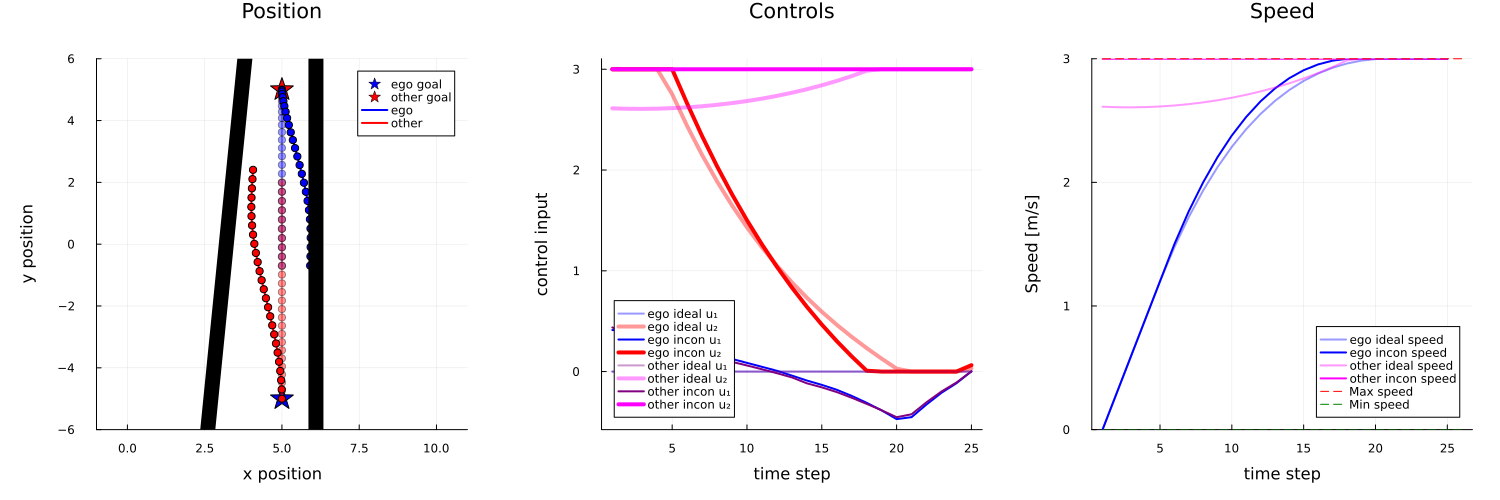

In [29]:
plot_solve_solution(ip, walls=[wall_1, wall_2], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [30]:
@time ibr(ip, 3, "ego")

  0.065153 seconds (252.32 k allocations: 21.781 MiB, 17.37% gc time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


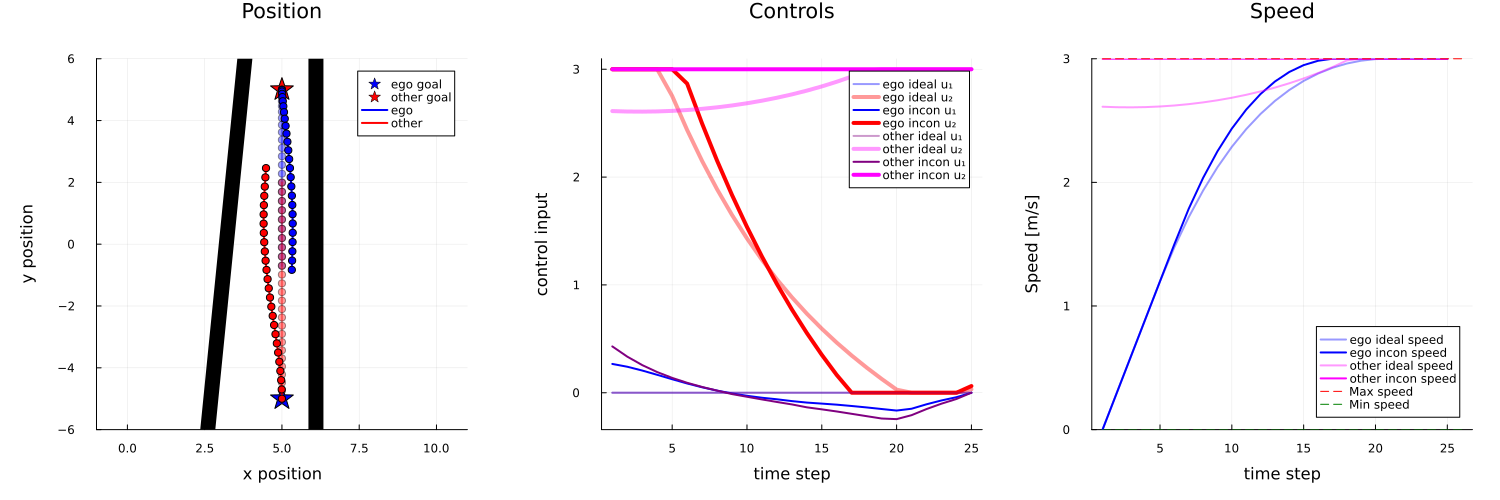

In [31]:
plot_solve_solution(ip, pos_xlims=[-1, 11], walls=[wall_1, wall_2], pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_KL2b0pShKv.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_KL2b0pShKv.gif")
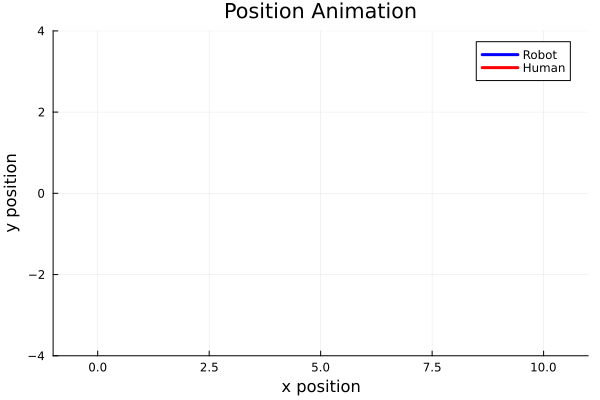

In [50]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

┌ Info: Saved animation to /tmp/jl_294zuvQT2l.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_294zuvQT2l.gif")
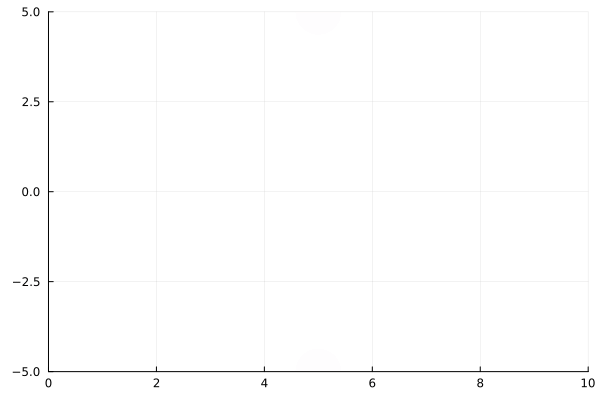

In [51]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [52]:
include("sim.jl")
include("mpc.jl")

mpc_step (generic function with 2 methods)

In [244]:
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 2.0

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 2.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([100.; 100.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([100.; 100.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [245]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [0.; 0.; pi; 2]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [246]:
dt = 0.1
velocity_max = 2.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 2.])

time_horizon = 20
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 100.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 20
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 100.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [247]:
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [248]:
robot_path, robot_controls, human_path, human_controls = simulate(robot_ip, human_ip, 50, leader="ego")

([0.0 0.0 0.0 2.0; 0.21499999900519567 0.0 -6.257250830125286e-5 2.2999999801039133; … ; 9.226987259842927 0.20042262756298823 -0.24895738282367555 0.5124329895596833; 9.275187098044194 0.18816870455957008 -0.24966878653738334 0.48222937156635093], [-0.0006257250830125286 2.9999998010391336; 0.04705232885623881 2.99999975042189; … ; -0.005335878597650124 -0.3605679689224981; -0.007114037137077965 -0.3020361799333235], [10.0 0.0 3.141592653589793 2.0; 9.800000115423556 0.00014768377419354696 3.140115815158795 1.9999991455632975; … ; 1.064842843318677 -0.044876364902171395 3.0995171416067926 0.9281537072270922; 0.9751578182940573 -0.04110059314981985 3.0995097975968213 0.8671357029786823], [-0.014768384309984147 -8.544367025478331e-6; -0.3607072925870292 -2.3506826559878294e-6; … ; -9.227339507912961e-5 -0.6339179167824177; -7.344009971469009e-5 -0.6101800424841001])

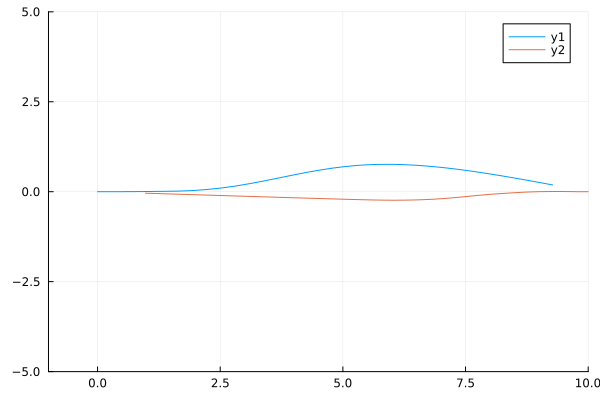

In [249]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-1, 10], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /tmp/jl_8d4PCfcVcV.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_8d4PCfcVcV.gif")
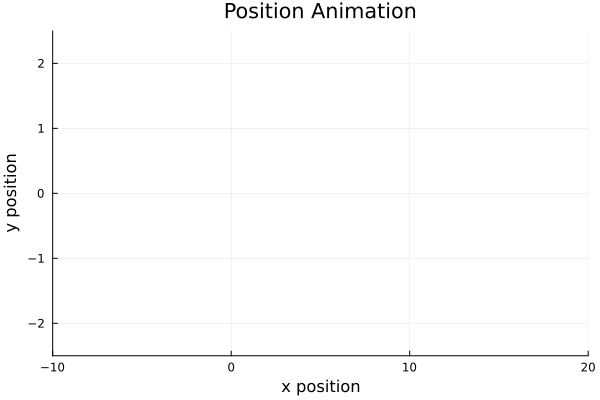

In [59]:
animation(robot_path, human_path, pos_xlims=[-10, 20], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [219]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 50
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 0.8
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 50
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 0.8
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [220]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [221]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.197735 seconds (819.24 k allocations: 80.190 MiB, 14.67% gc time)


  0.182221 seconds (756.60 k allocations: 72.995 MiB, 12.82% gc time)


In [222]:
saved_data_test_2, _, _, _, _ = ibr_save(ip, 3, "ego")

(SaveData
  previous_ips: Array{InteractionPlanner}((3,))
, [[-2.534246461325626e-10 3.225621974451111e-10 7.420910058780817e-11 -4.945240741941572e-10; 0.007786944755541648 -7.872097531956062e-5 -0.015212146891740592 0.15574782033566006; … ; 10.020198223649214 0.010421982449425576 0.09381829986051105 1.655953566897797; 10.18502914804408 0.02593004254777697 0.092889158181645 1.6552205279231544], [-1.4126410098484734e-10 2.1913904567094612e-10 8.78151891071036e-11 -3.6261078050387243e-10; 0.0074211245517085385 -7.084776605245317e-5 -0.014361727628538063 0.14843007602283928; … ; 9.992743356290422 0.005514114962575959 0.09266209871214218 1.6464058366087886; 10.156638973248574 0.020743531530251737 0.09174440037178369 1.6456252536350946], [-4.1849112625101753e-10 4.6251501692518486e-10 5.3468981045157797e-11 -8.732751887480305e-10; 0.007087329751351318 -6.403067655705897e-5 -0.01358805395154256 0.14175309612813183; … ; 9.969085486548346 0.001400268728799418 0.09168369505252173 1.63901357443

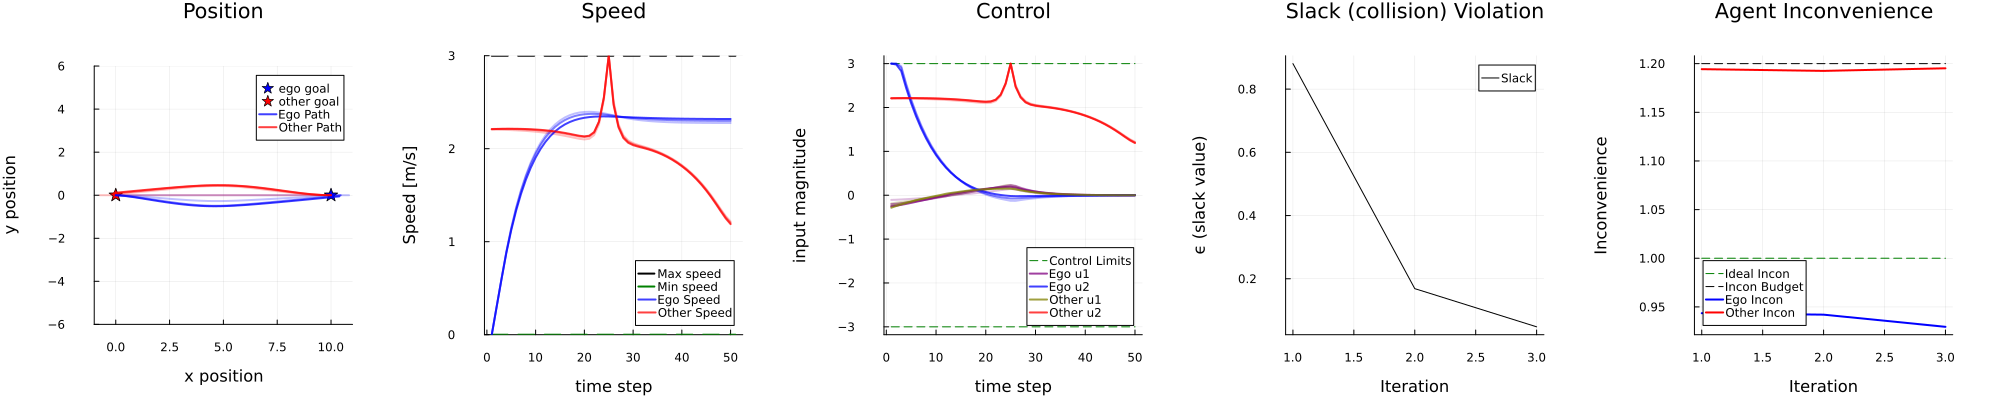

In [223]:
plot_example = plot_solve_solution(saved_data_test_1, scatter=false, show_speed=true, show_control=true)

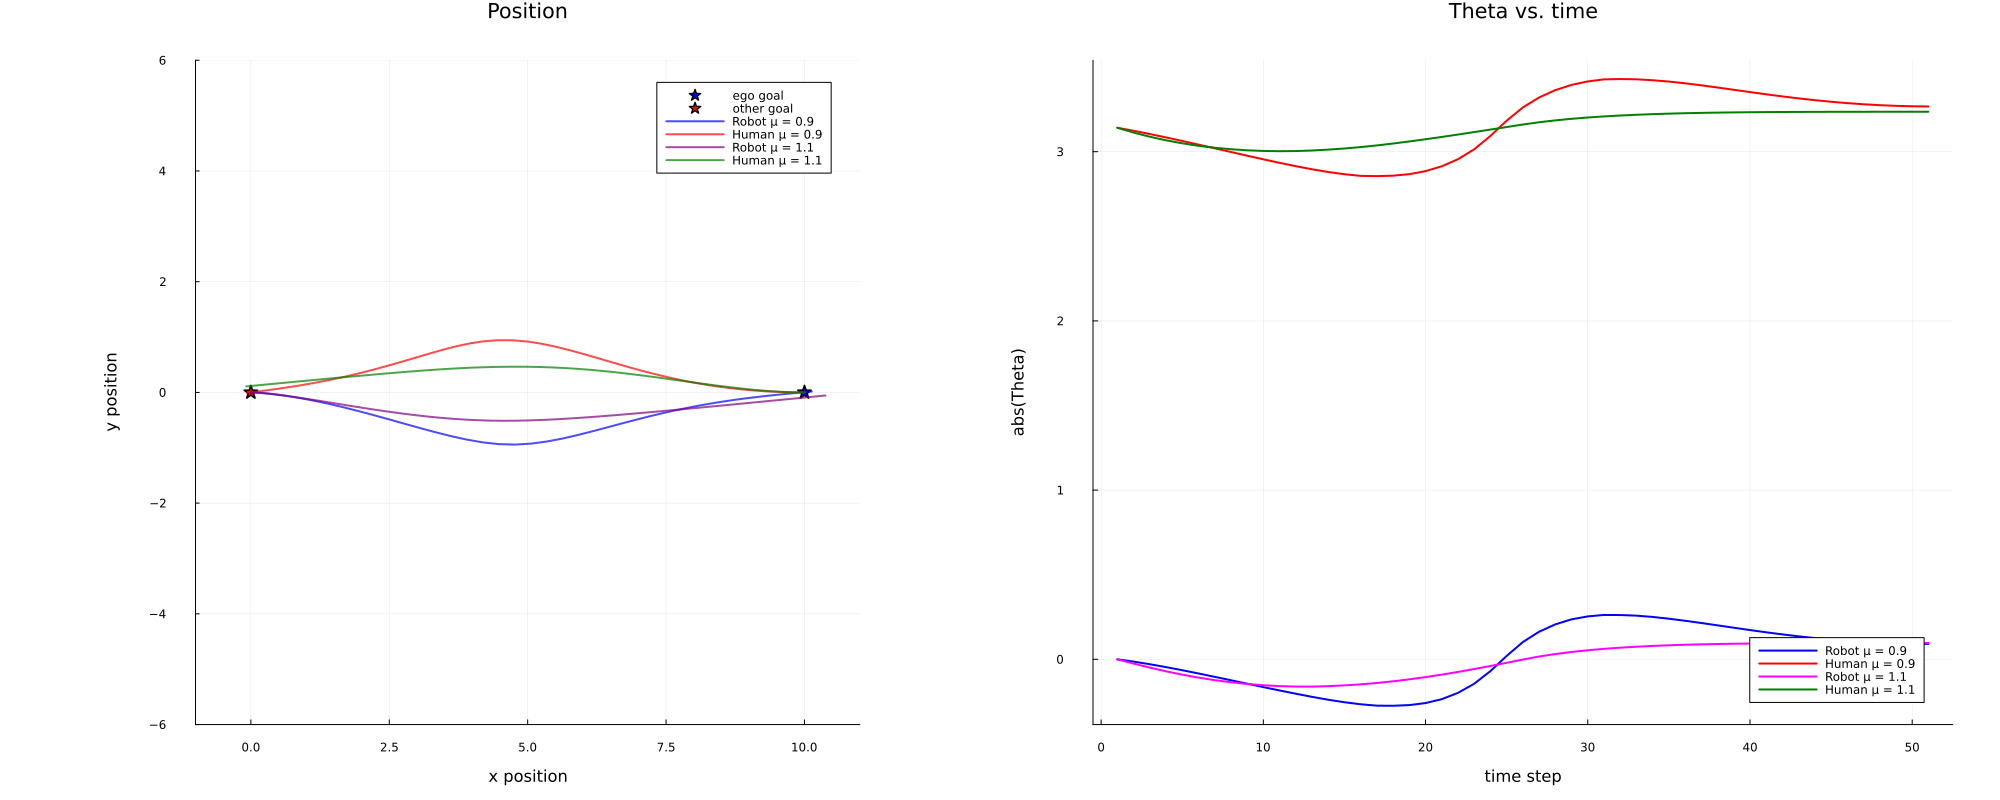

In [234]:
plot_solve_solution(saved_data_test_2, saved_data_test_1, true, scatter=false,show_control=false, show_speed=false)

In [233]:
function plot_solve_solution(problem::SaveData, second_problem::SaveData,show_theta::Bool; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b] 
    width=2000
    height=800
    alpha_plot = 0.7
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    global iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    global ego_ctrl_dim = 2
    global other_ctrl_dim = 2

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="Robot μ = 0.9", alpha=alpha_plot)

    plot!(plot_traj, value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=other_color, linewidth=linewidth, label="Human μ = 0.9", alpha=alpha_plot)


    plot!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=:purple, linewidth=linewidth, label="Robot μ = 1.1", alpha=alpha_plot)

    plot!(plot_traj, value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=:green, linewidth=linewidth, label="Human μ = 1.1", alpha=alpha_plot)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    plot_theta = plot(size=(height, height), xlabel="time step", ylabel="abs(Theta)", title="Theta vs. time", margin=10mm, legend=:bottomright)
    plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

    # angle plotting
    robot_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    robot_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    plot!(plot_theta, robot_xs_mu_09[:,3:3], linewidth=2, label="Robot μ = 0.9", color=ego_color)
    plot!(plot_theta, human_xs_mu_09[:,3:3], linewidth=2, label="Human μ = 0.9", color=other_color)
    plot!(plot_theta, robot_xs_mu_11[:,3:3], linewidth=2, label="Robot μ = 1.1", color=:magenta)
    plot!(plot_theta, human_xs_mu_11[:,3:3], linewidth=2, label="Human μ = 1.1", color=:green)

        # ctrl plotting
    plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="Control Limits")
    plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="")   
        # ego plot
    for j in 1:ego_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 
        # other plot
    for k in 1:other_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 


    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")

    plot(plot_traj, plot_theta, layout=l, size=(width, height))
end


plot_solve_solution (generic function with 9 methods)

# Sim Experimentation Utils

In [66]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)

PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [83.5189561605365, 84.37796338585994, 85.04058970525045, 85.53416516314202, 85.88510384150469, 86.11896984459398, 86.2606263823285, 86.33442702181163, 86.36442567357683, 86.37459739287459  …  86.99544999877935

In [67]:
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-85.51895615882756, -86.45570605963766, -87.34099812744309, -88.18017812434006, -88.97804691994335, -89.73893488797323, -90.46676595599283, -91.16511208888065, -91.83723889547186, -92.486143077511

In [68]:
sim_data = SimData(sim_params, robot_path, robot_controls, human_path, human_controls)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-85.51895615882756, -86.45570605963766, -87.34099812744309, -88.18017812434006, -88.97804691994335, -89.73893488797323, -90.46676595599283, -91.16511208888065, -91.83723889547186, -92.4861

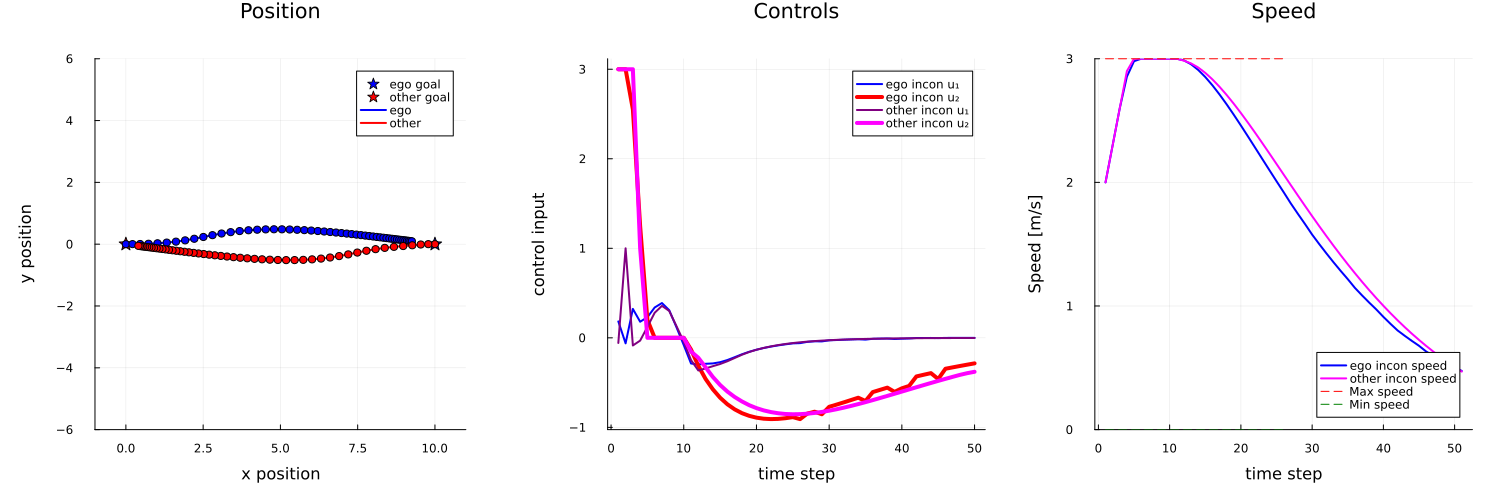

In [69]:
plot_solve_solution(sim_data)

# Experimentation Code

In [70]:
# for experiment in experiments
#     set up problem. Assign hyperparameters. Cycle through hps for each experiment
#     (markup, collision slack, trust region weights, incon weights, collision radius, incon ratio)
#     for opt_param in opt_params
#         assign new opt_params to the problem.
#         (initial states, goal states)
#         register the InteractionPlanner
#         run simulation
#         store data into dictionary w/ with key=run_number
#         (store: hps, opt_params, and paths) -- enough data to recreate the problem and plot Base.load_path_setup_code
#         delete interaction planner before cycling through the loop.
#     end
# end

In [34]:
using ProgressBars

In [35]:
# setting up the problem to be deep copied for experiments
# this is for experimentation where each agent correctly assumes the policy of the oteher agent

# setting up the robot planner
solver = "ECOS"

# defining initial and final states, these are the only things that will be changed in the opt_param sweeps
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2.]
human_goal_state = [0.; 0.; pi; 2.]

# defining the planning horizon and dt
time_horizon = 25
dt = 0.1

# some agent specific parametes
velocity_max_robot = 3.0
velocity_max_human = 3.

human = DynamicallyExtendedUnicycle(dt, velocity_max_human, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0

robot = DynamicallyExtendedUnicycle(dt, velocity_max_robot, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

# defining the robot ip
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
        
# defining the human ip, it will be the exact same as the robot ip, just in a different order

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


### Mohr's Circle-ish Implementation 

In [36]:
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [37]:
test_human = DynamicallyExtendedUnicycle(dt, velocity_max_human, [1., 1.5])

DynamicallyExtendedUnicycle{Float64}
  dt: Float64 0.1
  state_dim: Int64 4
  ctrl_dim: Int64 2
  velocity_min: Float64 0.0
  velocity_max: Float64 3.0
  control_min: Array{Float64}((2,)) [-1.0, -1.5]
  control_max: Array{Float64}((2,)) [1.0, 1.5]


In [38]:
robot_states = mohrs_circle_states(test_human, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [39]:
human_states = [([10., 0., pi, 0.], [0., 0., pi, 0.])]

1-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([10.0, 0.0, 3.141592653589793, 0.0], [0.0, 0.0, 3.141592653589793, 0.0])

### Simulation Code

In [47]:
sim_test = simulation_sweep(robot_ip, human_ip, robot_states, human_states)

0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


8.3%┣███▋                                       ┫ 1/12 [00:11<Inf:Inf, InfGs/it]


16.7%┣███████▊                                      ┫ 2/12 [00:22<03:36, 22s/it]


25.0%┣███████████▌                                  ┫ 3/12 [00:32<02:26, 16s/it]


33.3%┣███████████████▍                              ┫ 4/12 [00:43<01:54, 14s/it]


41.7%┣███████████████████▏                          ┫ 5/12 [00:53<01:32, 13s/it]


50.0%┣███████████████████████                       ┫ 6/12 [01:02<01:14, 12s/it]


58.3%┣██████████████████████████▉                   ┫ 7/12 [01:11<00:59, 12s/it]


66.7%┣██████████████████████████████▊               ┫ 8/12 [01:22<00:47, 12s/it]


75.0%┣██████████████████████████████████▌           ┫ 9/12 [01:33<00:35, 12s/it]


83.3%┣█████████████████████████████████████▌       ┫ 10/12 [01:44<00:23, 12s/it]


91.7%┣█████████████████████████████████████████▎   ┫ 11/12 [01:55<00:11, 11s/it]


100.0%┣████████████████████████████████████████████┫ 12/12 [02:05<00:00, 11s/it]
100.0%┣████████████████████████████████████████████┫ 12/12 [02:05<00:00, 11s/it]


Dict{Any, Any} with 12 entries:
  "Run 4"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 10" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 1"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 11" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 6"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 12" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 2"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 9"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 5"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 8"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 7"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 3"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float6

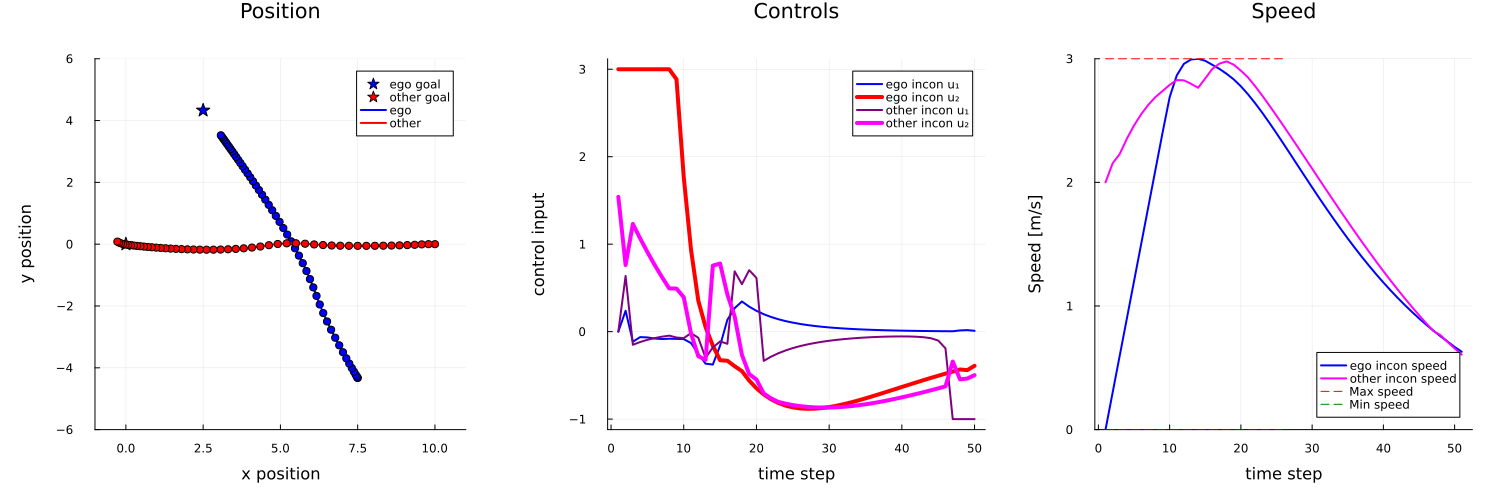

In [52]:
plot_solve_solution(sim_test["Run 5"], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Data Metrics

In [100]:
dt = sim_data.sim_params.ego_planner_params.hps.dynamics.dt
sim_horizon = length(sim_data.ego_states[:, 1])

ego_dyn = sim_data.sim_params.ego_planner_params.hps.dynamics
ego_xs = sim_data.ego_states
ego_us = sim_data.ego_controls
ego_goal = sim_data.sim_params.ego_planner_params.opt_params.goal_state

other_dyn = sim_data.sim_params.other_planner_params.hps.dynamics
other_xs = sim_data.other_states
other_us = sim_data.other_controls
other_goal = sim_data.sim_params.other_planner_params.opt_params.goal_state


4-element Vector{Float64}:
 0.0
 0.0
 3.141592653589793
 2.0

In [142]:
# Avg energy
avg_energy = sum(norm(ego_us[t, :]) * dt for t in 1:50) / sim_horizon

7.310262744617766

In [126]:
# Path Irregularity Index (PI)
ego_velocities = get_velocity(ego_dyn, matrix_to_vector_of_vectors(ego_xs)[1:end-1], matrix_to_vector_of_vectors(ego_us))
other_velocities = get_velocity(other_dyn, matrix_to_vector_of_vectors(other_xs)[1:end-1], matrix_to_vector_of_vectors(other_us))

50-element Vector{Matrix{Float64}}:
 [-2.0 2.4492935982947064e-16]
 [-2.299959143307858 0.01318795639600406]
 [-2.5884554825716712 -0.24470737927105654]
 [-2.889351828415363 -0.24824621768401553]
 [-2.989775225956334 -0.2474597665803089]
 [-2.986523239966342 -0.2840335400246188]
 [-2.977400358930123 -0.3675393098473409]
 [-2.9623807023775552 -0.47359718851632954]
 [-2.9468382865804945 -0.5622641336342249]
 [-2.939250802494977 -0.6006688270612976]
 ⋮
 [-0.8765162340390371 0.11395078923485921]
 [-0.8217259448592278 0.1071910392581031]
 [-0.7693237043915504 0.1006513626797048]
 [-0.7192801498234668 0.09434639948926658]
 [-0.6715726629320804 0.08828791783156982]
 [-0.6261246601161935 0.08247631650574723]
 [-0.5829177902206045 0.07692065247692169]
 [-0.5418945719925543 0.07162130966685908]
 [-0.5027586678261762 0.0665447620019945]

In [136]:
ego_PI = sum(acos(dot(ego_velocities[i][:], ego_goal[1:2] - ego_xs[i, 1:2]) / (norm(ego_velocities[i][:]) * norm(ego_goal[1:2] - ego_xs[i, 1:2]))) for i in 1:sim_horizon-1)
other_PI = sum(acos(dot(other_velocities[i][:], other_goal[1:2] - other_xs[i, 1:2]) / (norm(other_velocities[i][:]) * norm(other_goal[1:2] - other_xs[i, 1:2]))) for i in 1:sim_horizon-1)

2.9901590405132166

In [139]:
# Average acceleration per segment
i = 37
ego_a = (norm(ego_velocities[i]) - norm(ego_velocities[i-1])) / dt

-0.6061189224719632

In [141]:
ego_a = abs(sum((norm(ego_velocities[i]) - norm(ego_velocities[i-1])) / dt for i in 2:sim_horizon-1) / (sim_horizon - 1))

0.29938241396557985

In [143]:
ego_tnm = 0.0
for i in 2:sim_horizon
    if norm(ego_xs[i, 1:2] - ego_xs[i-1, 1:2]) / dt < 0.1
        ego_tnm += dt
    end
end

In [146]:
# Path efficiency
ego_PE = sum(norm(ego_xs[i, 1:2] - ego_xs[i-1, 1:2]) for i in 2:sim_horizon) / norm(ego_goal[1:2] - ego_xs[1, 1:2])
other_PE = sum(norm(other_xs[i, 1:2] - other_xs[i-1, 1:2]) for i in 2:sim_horizon) / norm(other_goal[1:2] - other_xs[1, 1:2])

0.9657097526606444

In [148]:
distances = [norm(ego_xs[i, 1:2] - other_xs[i, 1:2]) for i in 1:sim_horizon]

51-element Vector{Float64}:
 10.0
  9.570013919044355
  9.080410113453576
  8.534010567971594
  7.9490786079643545
  7.352876410565601
  6.757945804741374
  6.167405693851832
  5.583386246645449
  5.006726980768191
  ⋮
  7.8666539432507125
  8.018707797955441
  8.161745402876344
  8.295749662498485
  8.421177571076543
  8.538890782812466
  8.649253495048919
  8.75261028968943
  8.849269968998396

In [150]:
relative_v = [distances[i] - distances[i-1] for i in 2:sim_horizon]

50-element Vector{Float64}:
 -0.4299860809556453
 -0.48960380559077876
 -0.5463995454819823
 -0.5849319600072391
 -0.5962021973987532
 -0.594930605824227
 -0.5905401108895427
 -0.5840194472063827
 -0.5766592658772582
 -0.5698519623212421
  ⋮
  0.16147197507938582
  0.15205385470472876
  0.14303760492090234
  0.13400425962214157
  0.1254279085780574
  0.1177132117359232
  0.11036271223645322
  0.1033567946405114
  0.09665967930896535

In [157]:
# Sample vector
vector = [2, -3, 5, 0, 1, -4, 6]

# Filter out non-positive values and then find the index of the minimum
min_positive = minimum(filter(x -> x > 0, relative_v))
index_of_min_positive = argmin(abs.(relative_v .- min_positive))

println("Minimum positive value:", min_positive)
println("Index of minimum positive value:", index_of_min_positive)

Minimum positive value:0.09665967930896535
Index of minimum positive value:50
